In [ ]:
import pandas as pd

# --- Step 1: CPCB Daily ---
daily = pd.read_csv("/content/CPCB_NSIT_Dwarka_DailyMeans_2019_2024 (4).csv")
daily["Date"] = pd.to_datetime(daily["Date"], errors="coerce")
daily["Location"] = "Dwarka"

# --- Step 2: NASA POWER ---
nasa = pd.read_csv("POWER_Point_Daily_20190101_20250919_028d64N_077d22E_LST.csv", skiprows=11)
nasa["Date"] = pd.to_datetime(nasa["YEAR"].astype(str) + nasa["DOY"].astype(str), format="%Y%j")
nasa = nasa.replace(-999, pd.NA)   # Replace missing markers
nasa["Location"] = "Dwarka"

# --- Step 3: Merge Daily CPCB with NASA ---
merged_daily = pd.merge(daily, nasa, on=["Date","Location"], how="outer")
merged_daily = merged_daily.sort_values("Date").reset_index(drop=True)

# --- Save merged dataset ---
merged_daily.to_csv("Merged_CPCB_NASA_Daily_Dwarka.csv", index=False)

print("✅ Merged daily dataset saved as 'Merged_CPCB_NASA_Daily_Dwarka.csv'")


✅ Merged daily dataset saved as 'Merged_CPCB_NASA_Daily_Dwarka.csv'


In [ ]:
daily.columns

Index(['Date', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO (µg/m³)', 'NO2 (µg/m³)',
       'NOx (ppb)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)',
       'Ozone (µg/m³)', 'Benzene (µg/m³)', 'Toluene (µg/m³)', 'Xylene (µg/m³)',
       'O Xylene (µg/m³)', 'Eth-Benzene (µg/m³)', 'MP-Xylene (µg/m³)',
       'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'RF (mm)', 'TOT-RF (mm)',
       'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'Location'],
      dtype='object')

In [ ]:
nasa.columns

Index(['YEAR', 'DOY', 'RH2M', 'T2M', 'PRECTOTCORR', 'Date', 'Location'], dtype='object')

In [ ]:
import pandas as pd

# --- Step 1: CPCB Daily ---
daily = pd.read_csv("CPCB_NSIT_Dwarka_DailyMeans_2019_2024.csv")
daily["Date"] = pd.to_datetime(daily["Date"], errors="coerce")
daily["Location"] = "Dwarka"

# --- Step 2: NASA POWER Daily ---
# (skip metadata header lines in POWER file)
nasa = pd.read_csv("POWER_Point_Daily_20190101_20250919_028d64N_077d22E_LST.csv", skiprows=11)

# Convert YEAR+DOY into proper datetime
nasa["Date"] = pd.to_datetime(
    nasa["YEAR"].astype(str) + nasa["DOY"].astype(str),
    format="%Y%j"
)

# Replace missing markers (-999) with NaN
nasa = nasa.replace(-999, pd.NA)

# Add location column (same as CPCB station)
nasa["Location"] = "Dwarka"

# --- Step 3: Merge CPCB Daily + NASA ---
merged = pd.merge(
    daily,
    nasa,
    on=["Date", "Location"],
    how="outer"
)
merged = merged.sort_values("Date").reset_index(drop=True)

# --- Step 4: Handle Missing Values ---
# Create missing value flags
for col in merged.columns:
    if col not in ["Date", "Location"]:
        merged[f"{col}_missing"] = merged[col].isna().astype(int)

# Impute: forward-fill first, then fill remaining NaNs with column mean
merged_imputed = merged.copy()
merged_imputed.fillna(method="ffill", inplace=True)
merged_imputed.fillna(merged_imputed.mean(numeric_only=True), inplace=True)

# --- Step 5: Save both versions ---
merged.to_csv("Merged_CPCB_NASA_Dwarka_Flagged.csv", index=False)   # with missing flags
merged_imputed.to_csv("Merged_CPCB_NASA_Dwarka_Imputed.csv", index=False)  # imputed values

print("✅ Done! Two files created:")
print("   1. Merged_CPCB_NASA_Dwarka_Flagged.csv")
print("   2. Merged_CPCB_NASA_Dwarka_Imputed.csv")


/tmp/ipython-input-2929560753.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_imputed.fillna(method="ffill", inplace=True)
/tmp/ipython-input-2929560753.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_imputed.fillna(method="ffill", inplace=True)


✅ Done! Two files created:
   1. Merged_CPCB_NASA_Dwarka_Flagged.csv
   2. Merged_CPCB_NASA_Dwarka_Imputed.csv


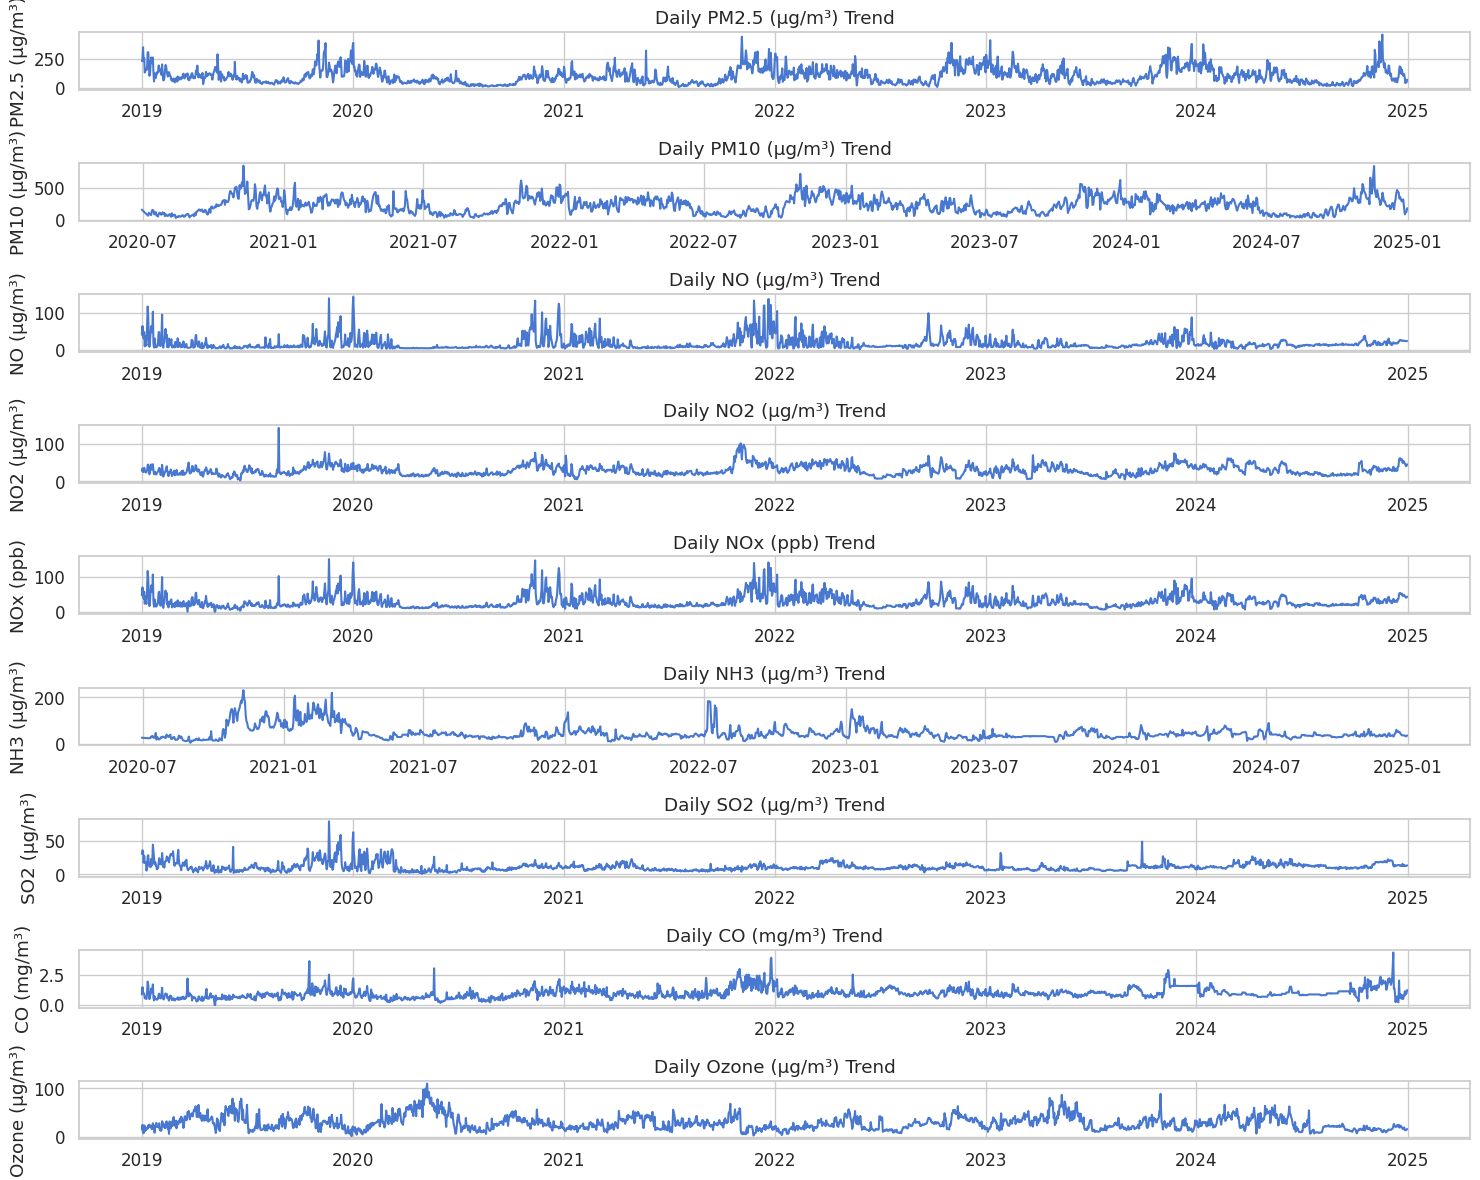

In [ ]:
# --- Step 0: Import libraries ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# --- Step 1: Load CSV ---
df = pd.read_csv("/content/Merged_CPCB_NASA_Dwarka_Flagged.csv")  # replace with your CSV file name
df['Date'] = pd.to_datetime(df['Date'])  # ensure Date is datetime

# --- Step 2: Select pollutants for plotting ---
pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO (µg/m³)', 'NO2 (µg/m³)',
              'NOx (ppb)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)',
              'Ozone (µg/m³)']

# --- Step 3: Daily time-series plots ---
plt.figure(figsize=(15,12))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(len(pollutants), 1, i)
    sns.lineplot(data=df, x='Date', y=pollutant)
    plt.title(f'Daily {pollutant} Trend')
    plt.xlabel('')
plt.tight_layout()
plt.show()



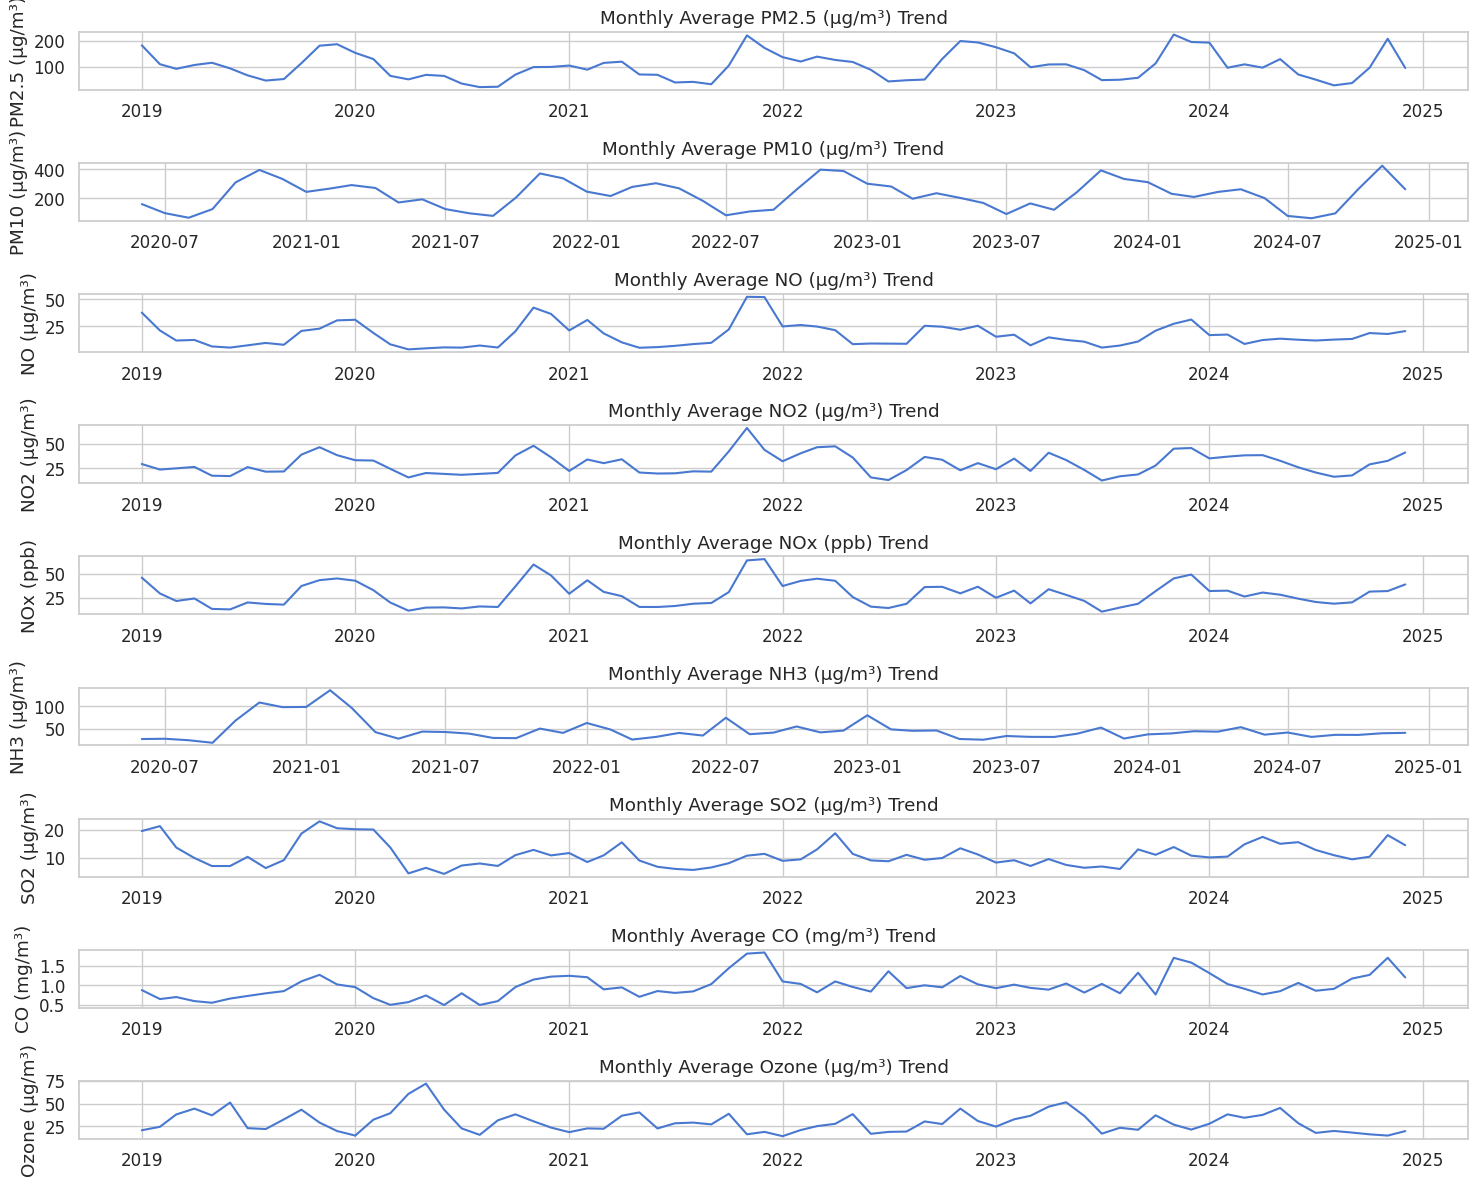

In [ ]:
# --- Step 4: Monthly aggregated plots ---
df['Month'] = df['Date'].dt.to_period('M')
monthly_df = df.groupby('Month')[pollutants].mean().reset_index()
monthly_df['Month'] = monthly_df['Month'].dt.to_timestamp()

plt.figure(figsize=(15,12))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(len(pollutants), 1, i)
    sns.lineplot(data=monthly_df, x='Month', y=pollutant)
    plt.title(f'Monthly Average {pollutant} Trend')
    plt.xlabel('')
plt.tight_layout()
plt.show()

/tmp/ipython-input-683819935.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill')  # fill missing values


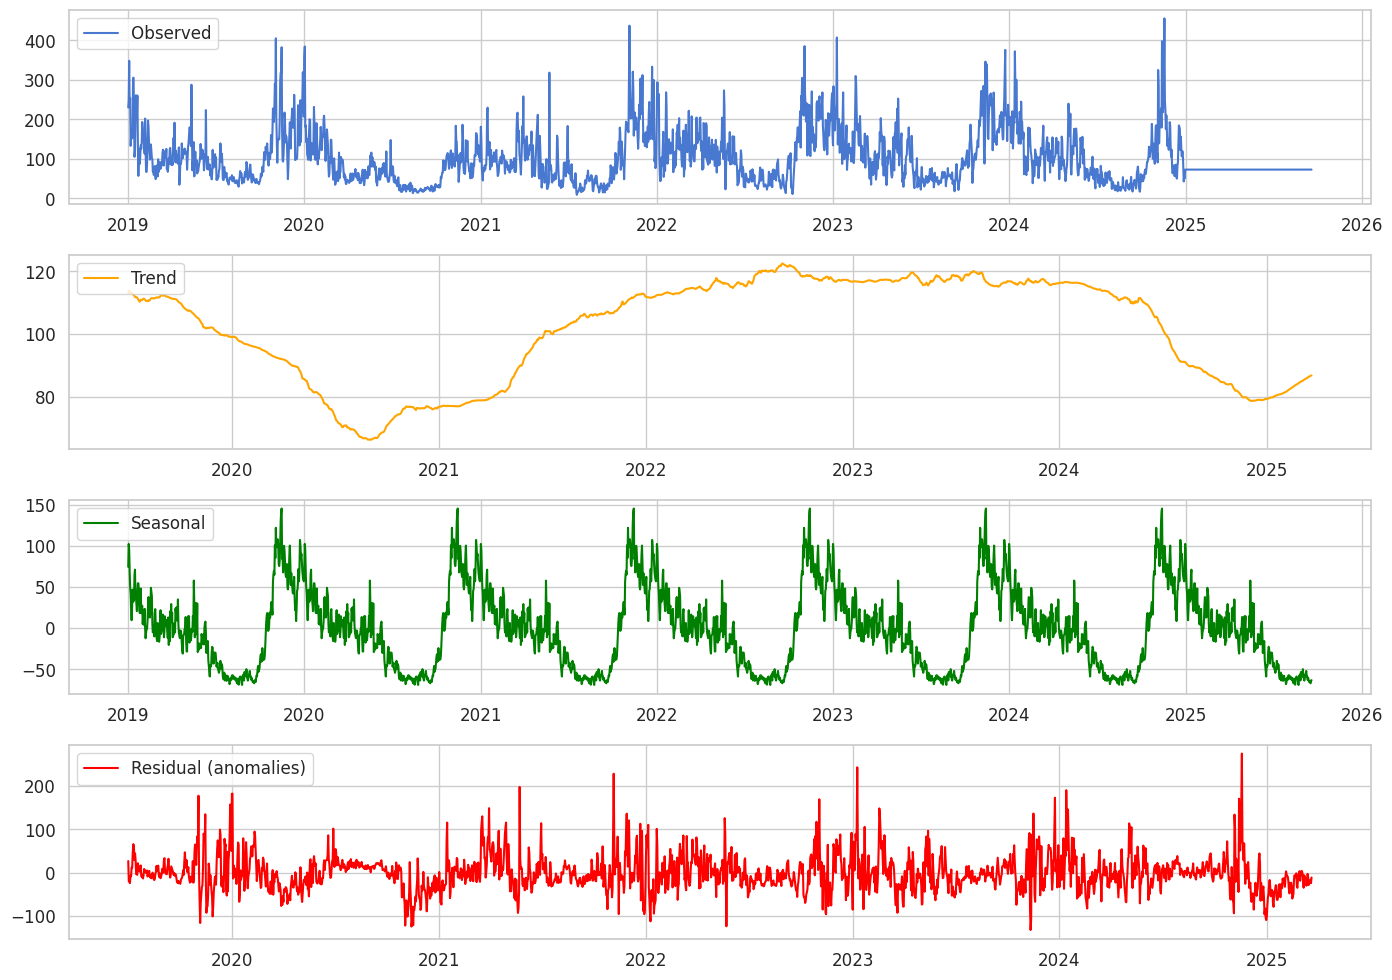

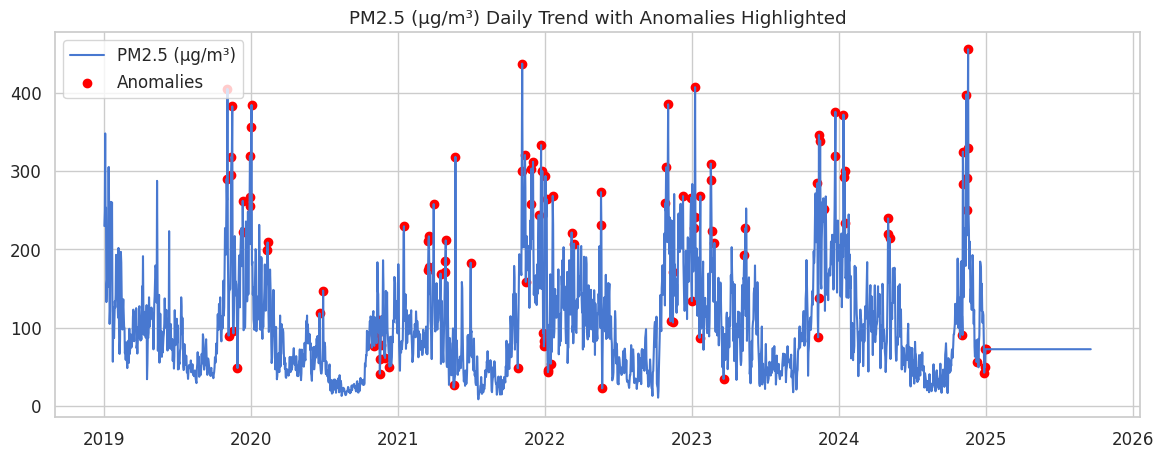

In [ ]:
# --- Step 0: Import libraries ---
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# --- Step 1: Load CSV ---
df = pd.read_csv("/content/Merged_CPCB_NASA_Daily_Dwarka.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')  # ensure time order

# --- Step 2: Select pollutant for decomposition ---
# Example: PM2.5
pollutant = 'PM2.5 (µg/m³)'

# --- Step 3: Set Date as index for time series ---
ts = df.set_index('Date')[pollutant].asfreq('D')  # daily frequency
ts = ts.fillna(method='ffill')  # fill missing values

# --- Step 4: Seasonal decomposition ---
result = seasonal_decompose(ts, model='additive', period=365)  # yearly seasonality

# --- Step 5: Plot decomposition ---
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residual (anomalies)', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# --- Step 6: Highlight anomalies (residuals > 2 std dev) ---
residual = result.resid
threshold = 2 * residual.std()
anomalies = residual[(residual > threshold) | (residual < -threshold)]

plt.figure(figsize=(14,5))
plt.plot(ts, label=pollutant)
plt.scatter(anomalies.index, ts[anomalies.index], color='red', label='Anomalies')
plt.title(f'{pollutant} Daily Trend with Anomalies Highlighted')
plt.legend()
plt.show()


/tmp/ipython-input-3825393754.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill')


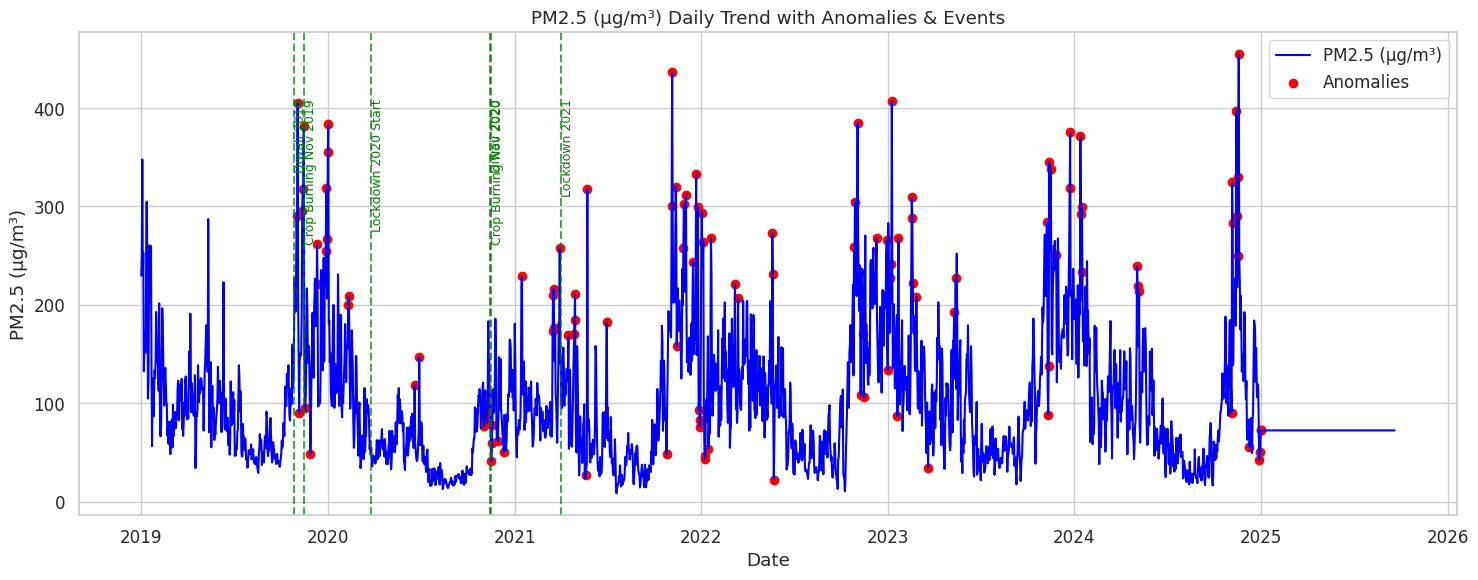

In [ ]:
# --- Step 0: Import libraries ---
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# --- Step 1: Load CSV ---
df = pd.read_csv("/content/Merged_CPCB_NASA_Daily_Dwarka.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

pollutant = 'PM2.5 (µg/m³)'

# --- Step 2: Set Date as index and fill missing ---
ts = df.set_index('Date')[pollutant].asfreq('D')
ts = ts.fillna(method='ffill')

# --- Step 3: Seasonal decomposition ---
result = seasonal_decompose(ts, model='additive', period=365)

residual = result.resid
threshold = 2 * residual.std()
anomalies = residual[(residual > threshold) | (residual < -threshold)]

# --- Step 4: Define known events for annotation ---
events = {
    "Diwali 2019": pd.Timestamp('2019-10-27'),
    "Crop Burning Nov 2019": pd.Timestamp('2019-11-15'),
    "Lockdown 2020 Start": pd.Timestamp('2020-03-25'),
    "Diwali 2020": pd.Timestamp('2020-11-14'),
    "Crop Burning Nov 2020": pd.Timestamp('2020-11-15'),
    "Lockdown 2021": pd.Timestamp('2021-04-01')  # example
}

# --- Step 5: Plot with anomalies and annotations ---
plt.figure(figsize=(15,6))
plt.plot(ts, label=pollutant, color='blue')
plt.scatter(anomalies.index, ts[anomalies.index], color='red', label='Anomalies')

# Annotate events
for event, date in events.items():
    if date in ts.index:
        plt.axvline(date, color='green', linestyle='--', alpha=0.7)
        plt.text(date, ts.max()*0.9, event, rotation=90, verticalalignment='top', fontsize=9, color='green')

plt.title(f'{pollutant} Daily Trend with Anomalies & Events')
plt.xlabel('Date')
plt.ylabel(f'{pollutant}')
plt.legend()
plt.tight_layout()
plt.show()


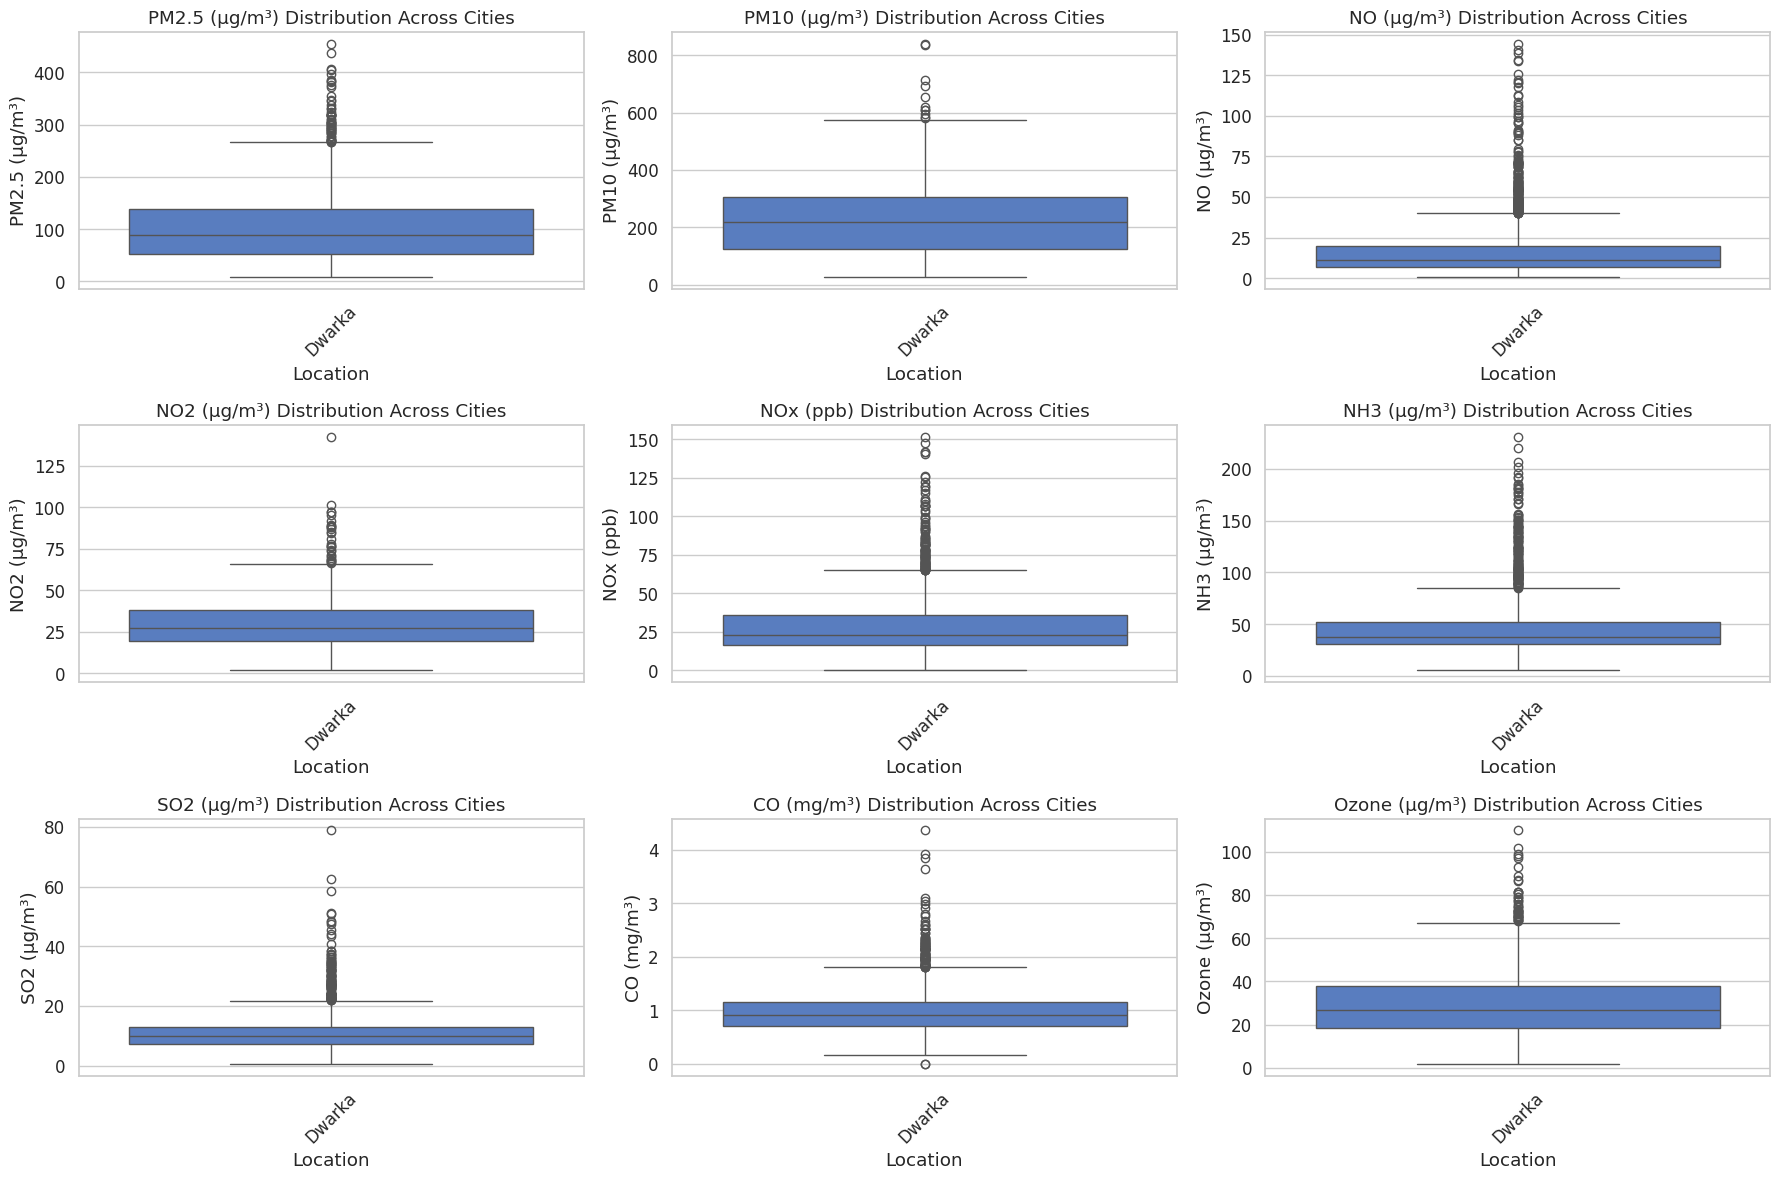

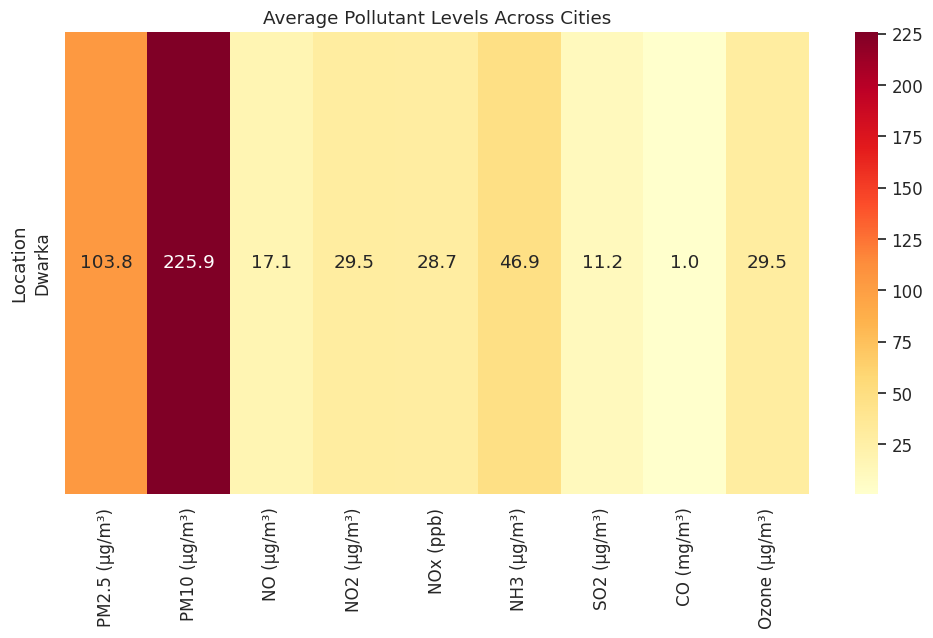

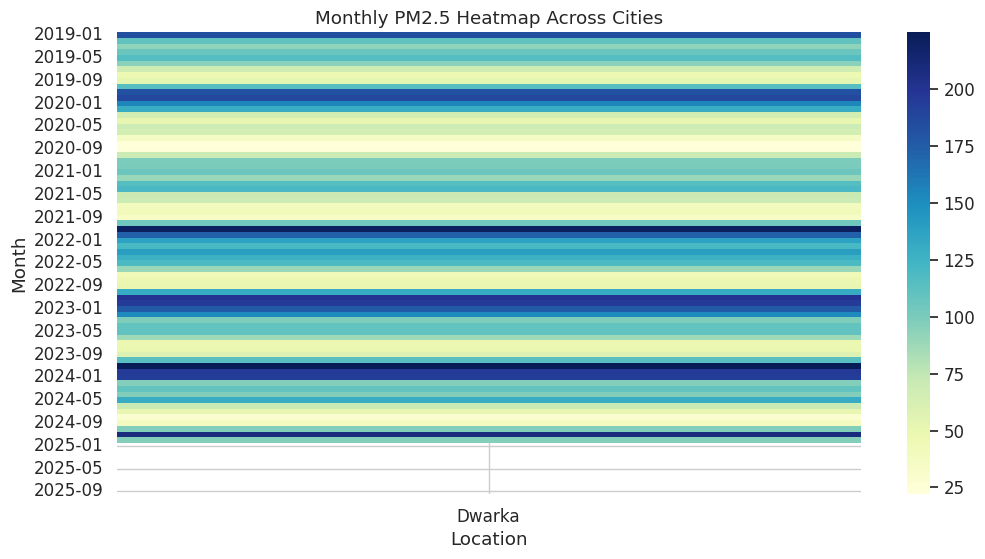

In [ ]:
# --- Step 0: Import libraries ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# --- Step 1: Load CSV ---
df = pd.read_csv("/content/CPCB_NSIT_Dwarka_DailyMeans_2019_2024.csv")
df['Date'] = pd.to_datetime(df['Date'])

# --- Step 2: Select pollutants ---
pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO (µg/m³)', 'NO2 (µg/m³)',
              'NOx (ppb)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)',
              'Ozone (µg/m³)']

# --- Step 3: Boxplots across cities ---
plt.figure(figsize=(18,12))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(3, 3, i)  # adjust grid size depending on number of pollutants
    sns.boxplot(data=df, x='Location', y=pollutant)
    plt.title(f'{pollutant} Distribution Across Cities')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Step 4: Heatmap of average pollutant levels per city ---
avg_city_pollutants = df.groupby('Location')[pollutants].mean()

plt.figure(figsize=(12,6))
sns.heatmap(avg_city_pollutants, annot=True, fmt=".1f", cmap='YlOrRd')
plt.title('Average Pollutant Levels Across Cities')
plt.show()

# --- Step 5 (Optional): Heatmap over time ---
# Pivot table: cities vs months
df['Month'] = df['Date'].dt.to_period('M')
monthly_avg = df.groupby(['Month', 'Location'])[pollutants].mean().reset_index()

# Example for PM2.5
pm25_pivot = monthly_avg.pivot(index='Month', columns='Location', values='PM2.5 (µg/m³)')
plt.figure(figsize=(12,6))
sns.heatmap(pm25_pivot, cmap='YlGnBu', annot=False)
plt.title('Monthly PM2.5 Heatmap Across Cities')
plt.show()


In [ ]:
print(df.columns)


In [ ]:
df.columns = df.columns.str.strip()


In [ ]:
print(df.columns)


In [ ]:
sns.boxplot(data=df, x='Location', y=pollutant)


In [ ]:
print(df.head())


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10,6))

sns.boxplot(data=df, x='Location', y=pollutant)
plt.xticks(rotation=45)
plt.title(f'{pollutant} Distribution Across Cities')
plt.show()


/tmp/ipython-input-3520662451.py:39: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  spearman_corr = df_sub[pollutants_aqi].corrwith(df_sub[met_vars], method="spearman")


Correlation Table:
    Pollutant/AQI Meteorological Variable   Pearson  Spearman
0   PM2.5 (µg/m³)                     T2M -0.447435 -0.449172
1   PM2.5 (µg/m³)                    RH2M -0.301357 -0.425988
2   PM2.5 (µg/m³)             PRECTOTCORR -0.310826 -0.647306
3    PM10 (µg/m³)                     T2M -0.405270 -0.411031
4    PM10 (µg/m³)                    RH2M -0.459877 -0.522982
5    PM10 (µg/m³)             PRECTOTCORR -0.374285 -0.711923
6     NO2 (µg/m³)                     T2M -0.315948 -0.358031
7     NO2 (µg/m³)                    RH2M -0.336906 -0.414452
8     NO2 (µg/m³)             PRECTOTCORR -0.215596 -0.497143
9     SO2 (µg/m³)                     T2M -0.033669 -0.099608
10    SO2 (µg/m³)                    RH2M -0.410624 -0.390893
11    SO2 (µg/m³)             PRECTOTCORR -0.194014 -0.380836
12  Ozone (µg/m³)                     T2M  0.155913  0.113860
13  Ozone (µg/m³)                    RH2M -0.381855 -0.384654
14  Ozone (µg/m³)             PRECTOTCORR -0.138590

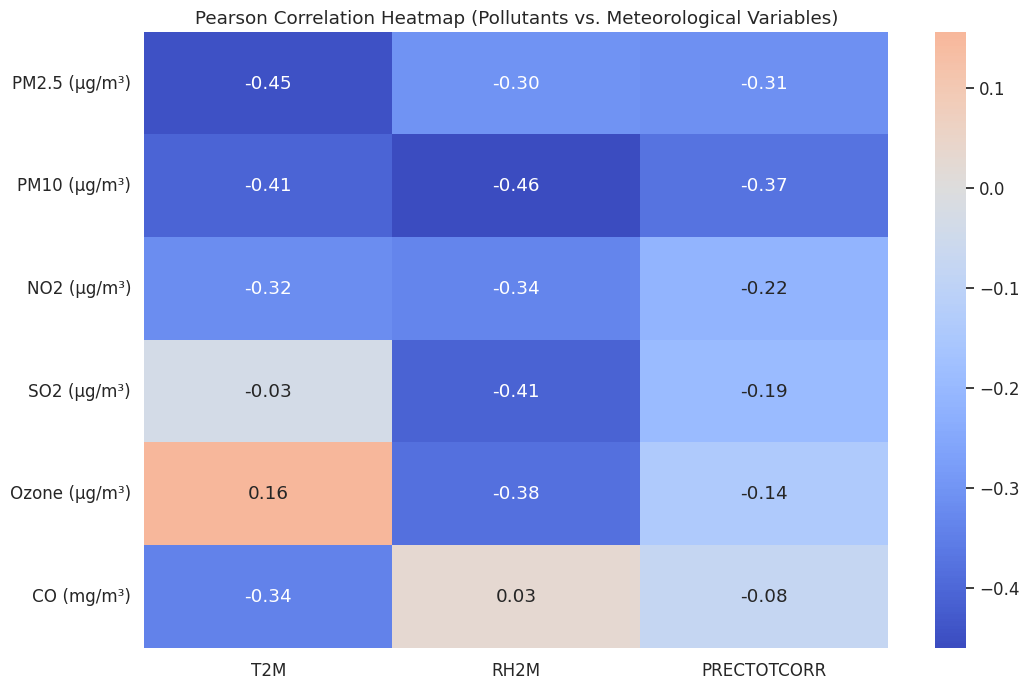

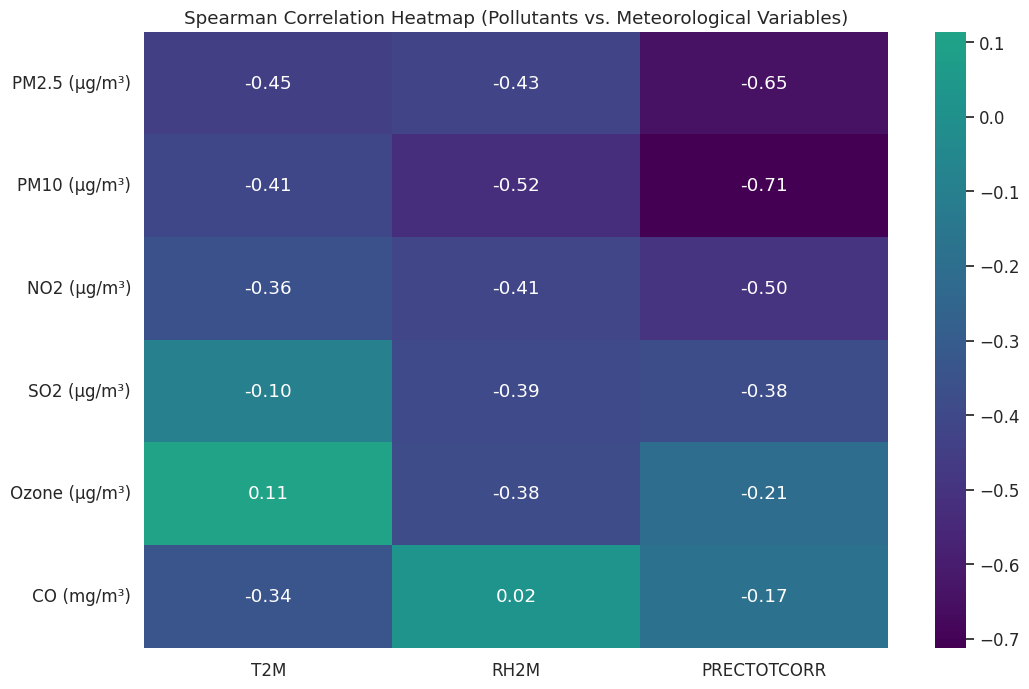

In [ ]:
import pandas as pd

# Example: load your merged dataset (CPCB + NASA POWER data)
# Replace with your actual file
df = pd.read_csv("/content/Merged_CPCB_NASA_Dwarka_Imputed.csv")

# --- Step 1: Define groups ---
pollutants_aqi = ["AQI", "PM2.5", "PM10", "NO2", "SO2", "O3", "CO"]
met_vars = ["T2M", "RH2M", "WS2M", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN"]
# (temperature, humidity, wind speed, precipitation, solar radiation etc.)
# adjust based on what your NASA dataset provides

# --- Step 2: Subset only relevant columns ---
df_sub = df[pollutants_aqi + met_vars].dropna()

# --- Step 3: Pearson correlation ---
pearson_corr = df_sub[pollutants_aqi].corrwith(df_sub[met_vars], method="pearson")

# --- Alternative way: full cross-correlation matrix ---
pearson_matrix = df_sub[pollutants_aqi].corrwith(df_sub[met_vars], axis=0, method="pearson")

# --- Step 4: Spearman correlation ---
spearman_corr = df_sub[pollutants_aqi].corrwith(df_sub[met_vars], method="spearman")

# --- Step 5: Build a combined correlation table ---
results = {}
for pol in pollutants_aqi:
    for met in met_vars:
        pear = df_sub[[pol, met]].corr(method="pearson").iloc[0,1]
        spear = df_sub[[pol, met]].corr(method="spearman").iloc[0,1]
        results[(pol, met)] = {"Pearson": pear, "Spearman": spear}

corr_df = pd.DataFrame(results).T.reset_index()
corr_df.columns = ["Pollutant/AQI", "Meteorological Variable", "Pearson", "Spearman"]

# --- Display nicely ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(corr_df.head())

# Optional: Heatmap visualization
plt.figure(figsize=(12,6))
sns.heatmap(df_sub.corr(method="pearson"), annot=False, cmap="coolwarm", center=0)
plt.title("Pearson Correlation Heatmap (Pollutants + Meteorological Variables)")
plt.show()

plt.figure(figsize=(12,6))
sns.heatmap(df_sub.corr(method="spearman"), annot=False, cmap="viridis", center=0)
plt.title("Spearman Correlation Heatmap (Pollutants + Meteorological Variables)")
plt.show()


In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Load your dataset (replace with imputed CSV ideally)
# Using the imputed dataset as it has no missing values
df = pd.read_csv("/content/Merged_CPCB_NASA_Dwarka_Imputed.csv")

# --- Define columns ---
# Updated pollutant name to match DataFrame columns
pollutant = "PM2.5 (µg/m³)"
# Updated features to include available meteorological variables
features = ["T2M", "RH2M", "PRECTOTCORR"]
# (temperature, humidity, precipitation)

# --- Subset ---
# Ensure columns exist before subsetting
existing_cols = [col for col in [pollutant] + features if col in df.columns]

# Check if pollutant and all features exist
if pollutant in existing_cols and all(f in existing_cols for f in features):
    df_model = df[existing_cols].dropna()

    X = df_model[features]
    y = df_model[pollutant]

    # --- 1. Statsmodels (gives full regression summary like R, p-values etc.) ---
    X_const = sm.add_constant(X)  # add intercept
    model = sm.OLS(y, X_const).fit()
    print(model.summary())

    # --- 2. Scikit-learn (for prediction + metrics) ---
    lr = LinearRegression()
    lr.fit(X, y)

    y_pred = lr.predict(X)

    print("\nScikit-learn Regression Results:")
    print(f"Intercept: {lr.intercept_}")
    print(f"Coefficients: {dict(zip(features, lr.coef_))}")
    print(f"R² Score: {r2_score(y, y_pred):.3f}")
    print(f"RMSE: {mean_squared_error(y, y_pred, squared=False):.3f}")
else:
    print(f"Error: Pollutant '{pollutant}' or some features ({features}) not found in the DataFrame.")

                            OLS Regression Results                            
Dep. Variable:          PM2.5 (µg/m³)   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     366.0
Date:                Fri, 26 Sep 2025   Prob (F-statistic):          2.21e-196
Time:                        11:19:45   Log-Likelihood:                -13231.
No. Observations:                2454   AIC:                         2.647e+04
Df Residuals:                    2450   BIC:                         2.649e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         247.0983      5.238     47.175      

TypeError: got an unexpected keyword argument 'squared'

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Normal MSE
mse = mean_squared_error(y, y_pred)

# RMSE = sqrt(MSE)
rmse = np.sqrt(mse)

print(f"R² Score: {r2_score(y, y_pred):.3f}")
print(f"RMSE: {rmse:.3f}")


R² Score: 0.309
RMSE: 53.123


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# --- Load Data ---
df = pd.read_csv("/content/Merged_CPCB_NASA_Daily_Dwarka.csv")

# --- Define target & features based on your column names ---
target = "Ozone (µg/m³)"  # Use exact name from df.columns
features = ["T2M", "RH2M", "PRECTOTCORR"]

# --- Check columns ---
print("Available columns:", df.columns.tolist())
print("Using target:", target)
print("Using features:", features)

# --- Filter data ---
df_model = df[[target] + features].dropna()

X = df_model[features].values
y = df_model[target].values

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Scale features ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Build ANN ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(len(features),)),
    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- Train ---
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=50, batch_size=16, verbose=1)

# --- Evaluate ---
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {mae:.2f}")


Available columns: ['Date', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO (µg/m³)', 'NO2 (µg/m³)', 'NOx (ppb)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)', 'Ozone (µg/m³)', 'Benzene (µg/m³)', 'Toluene (µg/m³)', 'Xylene (µg/m³)', 'O Xylene (µg/m³)', 'Eth-Benzene (µg/m³)', 'MP-Xylene (µg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'RF (mm)', 'TOT-RF (mm)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'Location', 'YEAR', 'DOY', 'RH2M', 'T2M', 'PRECTOTCORR']
Using target: Ozone (µg/m³)
Using features: ['T2M', 'RH2M', 'PRECTOTCORR']
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1005.4226 - mae: 28.0370 - val_loss: 698.7323 - val_mae: 22.5373
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 522.4574 - mae: 17.9340 - val_loss: 197.6654 - val_mae: 10.6402
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 218.6570 - mae: 11.0091 - val_loss: 184.6707 - val_mae: 10.2887
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 224.6327 - mae: 11.1712 - val_loss: 176.4378 - val_mae: 10.0259
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 205.6845 - mae: 10.7768 - val_loss: 172.0969 - val_mae: 9.8345
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 186.8473 - mae: 10.2164 - val_loss: 166.9241 - val_mae: 9.7697
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 185.5702 - mae: 10.4517 - val_loss: 163.9542 - val_mae: 9.6395
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 187.6853 - mae: 10.4892 - val_loss: 163.3968 - val_mae: 9.6962
Epoch 9/50
110/110 ━━━

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# --- Load your dataset ---
df = pd.read_csv("/content/Merged_CPCB_NASA_Daily_Dwarka.csv")

# --- Define pollutants and meteorological features ---
pollutants = [
    "PM2.5 (µg/m³)", "PM10 (µg/m³)", "NO2 (µg/m³)",
    "SO2 (µg/m³)", "CO (mg/m³)", "Ozone (µg/m³)"
]
met_features = ["T2M", "RH2M", "PRECTOTCORR", "WS (m/s)"]
# you can adjust features (temperature, humidity, rainfall, wind speed)

results = {}

# --- Loop through pollutants ---
for pollutant in pollutants:
    if pollutant in df.columns:
        # Keep only valid rows
        df_model = df[[pollutant] + met_features].dropna()

        if df_model.empty:
            continue

        X = df_model[met_features]
        y = df_model[pollutant]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Linear regression
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict and calculate R²
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        results[pollutant] = round(r2 * 100, 2)  # % variance explained

# --- Print results ---
print("Meteorological Influence (% Variance Explained):")
for pollutant, var_exp in results.items():
    print(f"{pollutant}: {var_exp}%")


Meteorological Influence (% Variance Explained):
PM2.5 (µg/m³): 44.22%
PM10 (µg/m³): 54.21%
NO2 (µg/m³): 39.12%
SO2 (µg/m³): 9.7%
CO (mg/m³): 14.85%
Ozone (µg/m³): 17.83%


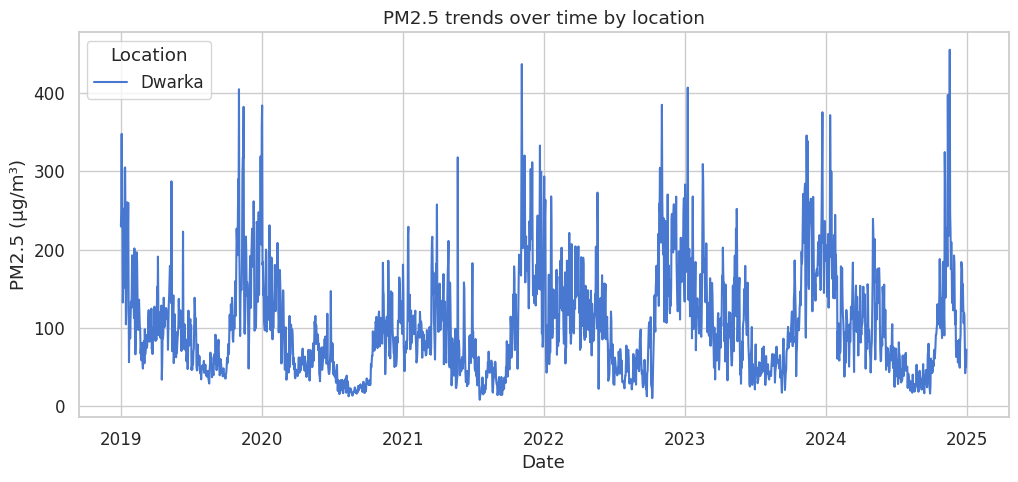

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load dataset ---
df = pd.read_csv("/content/Merged_CPCB_NASA_Daily_Dwarka.csv")

# Example columns you might have
# 'Date', 'Location', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'Lockdown' (1 = lockdown, 0 = no lockdown)
# 'TrafficIndex', 'IndustrialActivity', etc.

# --- Convert date ---
df['Date'] = pd.to_datetime(df['Date'])

# --- Create Month-Year column to compare pre/post events ---
df['YearMonth'] = df['Date'].dt.to_period('M')

# --- Example 1: Lockdown effect ---
if 'Lockdown' in df.columns:
    lockdown_summary = df.groupby('Lockdown')['PM2.5 (µg/m³)'].mean()
    print("Average PM2.5 during lockdown vs non-lockdown:")
    print(lockdown_summary)

    # Boxplot
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Lockdown', y='PM2.5 (µg/m³)', data=df)
    plt.title("PM2.5 levels during Lockdown vs Non-Lockdown")
    plt.show()

# --- Example 2: Local source effect (traffic/industry proxies) ---
source_vars = [col for col in df.columns if 'Traffic' in col or 'Industrial' in col]
for source in source_vars:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=source, y='PM2.5 (µg/m³)', data=df)
    plt.title(f"PM2.5 vs {source}")
    plt.show()

# --- Example 3: Trend analysis (emissions changes over time) ---
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='Date', y='PM2.5 (µg/m³)', hue='Location')
plt.title("PM2.5 trends over time by location")
plt.show()

# Optional: compute correlation between PM2.5 and traffic/industry activity
if source_vars:
    corr_matrix = df[['PM2.5 (µg/m³)'] + source_vars].corr()
    print("Correlation with local sources:")
    print(corr_matrix['PM2.5 (µg/m³)'])
